# DPCM

Vamos rever o exemplo visto na aula introdutória. Ao invés de utilizar as diferenças, utilizaremos o DPCM.

Note que utilizar as diferenças, como feito no exemplo introdutório, pode ser compreendido como um DPCM com preditor *naïve* (ingênuo) e *codebook* para erro com 2 vezes o número de bits utilizado por pixel na imagem original.

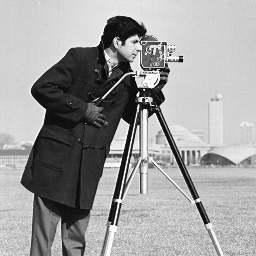

In [10]:
pkg load communications;
X = imread('imgs/cman.png');
imshow(X);
sX = size(X);
oX = X;

Faremos o mesmo pré-processamento feito anteriormente (varredura progressiva da imagem). Ao final teremos um vetor. Para as funções de DPCM o vetor deve ser um vetor linha, por isso temos um último transposto, além do que foi utilizado no exemplo introdutório.

In [11]:
idodd = 1:2:size(X,2);
X(idodd,:) = fliplr ( X(idodd,:) );
X = double( X'(:) )';

Vamos utilizar o DPCM com um preditor de 2a ordem e um *codebook* para o erro utilizando 3 bits. Para otimizar o preditor e *codebook*, iremos utilizar a função *dpcmopt*.

In [5]:
nbits = 3; order = 2;
[predictor, codebook, partition] = dpcmopt(X, order, 2^nbits);

Vamos verificar se o filtor encontrado é estável (todos os pólos dentro do círculo unitário).

In [7]:
r = roots([1 predictor(2:end)]);
if any( abs(r)>1 ), figure; zplane(1,[1 predictor(2:end)]); error('filtro instavel'); else, disp('filtro estavel (ok)'); end;

filtro estavel (ok)


Agora podemos codificar o sinal utilizando o DPCM.

In [8]:
qidx = dpcmenco(X, codebook, partition, predictor);

Por fim, vamos verificar o resultado, a imagem codificada com DPCM. Faremos então a decodificação e os passos inversos, do pré-processamento.

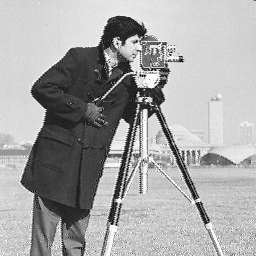

In [9]:
y = dpcmdeco(qidx, codebook, predictor);
Y = uint8(reshape(y', sX)');
Y(idodd,:) = fliplr ( Y(idodd,:) );
imshow(Y);

Irmeos agora analisar o histograma da imagem original e o histograma de utilização do *codebook* na codificação desta imagem.

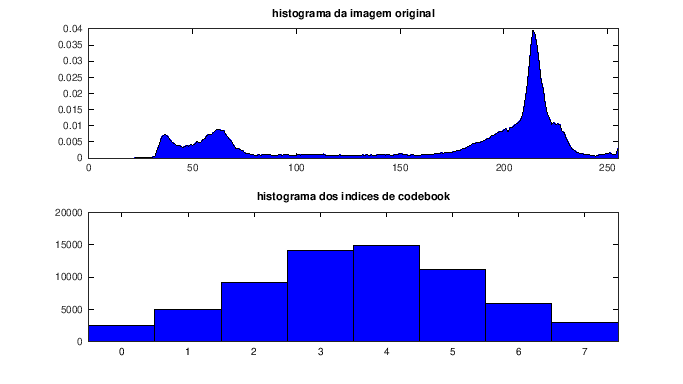

In [12]:
hx = hist(X,[0:255]);
figure("position",get(0,"screensize")./[1 1 2 2])
subplot(2,1,1);
area([0:255],hx./sum(hx),'facecolor','b');
ax = axis; ax(1)=0; ax(2)=255; axis(ax);
title('histograma da imagem original');
subplot(2,1,2);
[hq, nq] = hist(qidx,[0:2^nbits-1]);
bar(nq, hq, 'hist', 'b');
axd = axis; axd(1)=-0.5; axd(2)=2^nbits-1+0.5; axis(axd);
title('histograma dos indices de codebook');

Por fim, iremos novamente propor um código de Huffman para codificar os índices de *codebook* na saída e verificar qual quantos bits seria necessários para codificar o sinal usando DPCM e compara com o tamanho da imagem original.

Tamanho original = 524288 bits
Tamanho comprimido = 183728 bits
Taxa de compressao = 0.35


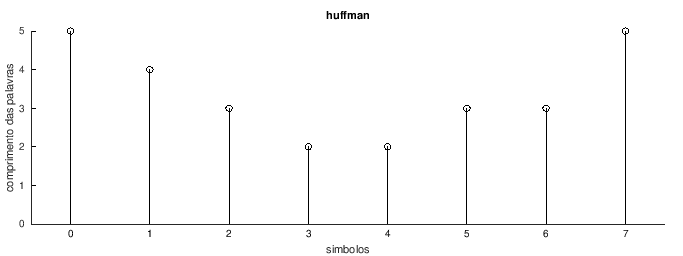

In [13]:
hqdadd1 = hq + ones(size(hq)); % add one smoothing
dict = huffmandict([0:2^nbits-1], hqdadd1./sum(hqdadd1));
len = []; for i = 1:length(dict), len(i)=length(dict{i}); endfor;
figure("position",get(0,"screensize")./[1 1 2 3])
stem([0:2^nbits-1],len,'k-','linewidth',2);
axh=axis; axh(1)=-0.5; axh(2)=2^nbits-1+0.5; axis(axh); set(gca,'xtick',[0:2^nbits-1]);
xlabel('simbolos'); ylabel('comprimento das palavras'); title('huffman');
tamfinal = sum(hq.*len) + order * 64; % doubles (64 bits)
printf('Tamanho original = %d bits\nTamanho comprimido = %d bits\nTaxa de compressao = %.2f\n', length(X)*8, tamfinal, tamfinal/(length(X)*8));